# IMT 547 Project Part IV: Analysis

Chesie Yu

03/07/2024

<style type = "text/css">  
    body {
        font-family: "Serif"; 
        font-size: 12pt;
    }
    em {
        color: #4E7F9E;
    }
    strong {
        color: #436D87;
    }
    li {
        color: #4E7F9E;
    }
    ul {
        color: #4E7F9E;
    }
    img {
        display: block;
        margin: auto;
    } 
    .jp-RenderedHTMLCommon a:link { 
        color: #94C1C9;
    }
    .jp-RenderedHTMLCommon a:visited { 
        color: #94C1C9;
    }
    .jp-RenderedHTMLCommon code {
        color: #4E7F9E;
    }  
    .mark {
        color: #B00D00;
        background-color: #FFF7B1;
    }
</style>

In [1]:
# Import the libraries
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
from statsmodels.formula.api import ols, logit

# Ignore future warnings
warnings.filterwarnings("ignore", category=FutureWarning)

## 0. Load the Data

In [2]:
# Load the data
yt = pd.read_csv("../data/yt-labeled.csv")
yt.head(3)

,channel_id,channel_name,channel_description,channel_country,channel_uploads_id,channel_viewcount,channel_subscribercount,channel_videocount,video_id,video_title,...,comment_weapon,comment_children,comment_monster,comment_ocean,comment_giving,comment_contentment,comment_writing,comment_rural,comment_positive_emotion,comment_musical
0,UC-lHJZR3Gqxm24_Vd_AJ5Yw,PewDiePie,I make videos.,JP,UU-lHJZR3Gqxm24_Vd_AJ5Yw,29238461440,111000000,4753,F-yEoHL7MYY,I t̶r̶i̶e̶d̶ ̶t̶o̶ beat Elden Ring Without Dyi...,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,UC-lHJZR3Gqxm24_Vd_AJ5Yw,PewDiePie,I make videos.,JP,UU-lHJZR3Gqxm24_Vd_AJ5Yw,29238461440,111000000,4753,F-yEoHL7MYY,I t̶r̶i̶e̶d̶ ̶t̶o̶ beat Elden Ring Without Dyi...,...,0.0,0.0,0.0,0.0,0.0,0.1,0.0,0.0,0.1,0.0
2,UC-lHJZR3Gqxm24_Vd_AJ5Yw,PewDiePie,I make videos.,JP,UU-lHJZR3Gqxm24_Vd_AJ5Yw,29238461440,111000000,4753,F-yEoHL7MYY,I t̶r̶i̶e̶d̶ ̶t̶o̶ beat Elden Ring Without Dyi...,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [3]:
# Check the dimensions
print(f"Number of rows: {yt.shape[0]}\n"
      f"Number of columns: {yt.shape[1]}\n")

# Check for missing values
print(f"Number of missing values: {yt.isna().sum().sum()}")

Number of rows: 124704
Number of columns: 448

Number of missing values: 0


## 1. Toxicity at Different Levels

In [4]:
# Define the threshold alpha
alpha = 0.5

# Create binary labels for toxicity
yt["video_toxicity_label"] = (yt["video_toxicity"] > 0.5).astype(int)
yt["comment_toxicity_label"] = (yt["comment_toxicity"] > 0.5).astype(int)

### Channel

#### Video Toxicity vs Comment Toxicity

In [5]:
# Number of videos in each genre for each channel
channel_video_counts = \
    yt.groupby(["channel_id", "channel_name", "video_genre"])["video_id"].nunique()\
      .reset_index(name="video_count")\
      .pivot_table(index=["channel_id", "channel_name"],
                   columns="video_genre",
                   values="video_count",
                   fill_value=0)\
      .reset_index()\
      .rename_axis(None, axis=1)\
      .rename(columns={"action": "action_count", "non-action": "nonaction_count"})

# Fix data types
channel_video_counts["action_count"] = channel_video_counts["action_count"].astype(int)
channel_video_counts["nonaction_count"] = channel_video_counts["nonaction_count"].astype(int)

# Compute total video count
channel_video_counts["video_count"] = channel_video_counts["action_count"] + channel_video_counts["nonaction_count"]

# Compute action video proportion
channel_video_counts["action_proportion"] = channel_video_counts["action_count"] / channel_video_counts["video_count"] 
channel_video_counts.sort_values(by="action_proportion", ascending=False).head()

,channel_id,channel_name,action_count,nonaction_count,video_count,action_proportion
16,UCWsDFcIhY2DBi3GB5uykGXA,IShowSpeed,5,0,5,1.000000
21,UCiYcA0gJzg855iSKMrX3oHg,CoryxKenshin,30,7,37,0.810811
17,UCYVinkwSX7szARULgYpvhLw,Ali-A,29,7,36,0.805556
24,UCpB959t8iPrxQWj7G6n0ctQ,SSSniperWolf,26,9,35,0.742857
26,UCq6VFHwMzcMXbuKyG7SQYIg,penguinz0,29,15,44,0.659091


In [6]:
# Average video and comment toxicity for each channel
channel_toxicity = yt.groupby("channel_id")[[
    "video_toxicity", "comment_toxicity",
    "video_toxicity_label", "comment_toxicity_label"
]].mean().reset_index("channel_id").rename(columns={
    "video_toxicity_label": "video_toxicity_proportion",
    "comment_toxicity_label": "comment_toxicity_proportion"
})
channel_toxicity.head()

,channel_id,video_toxicity,comment_toxicity,video_toxicity_proportion,comment_toxicity_proportion
0,UC-lHJZR3Gqxm24_Vd_AJ5Yw,0.432739,0.172895,0.119141,0.054883
1,UC0DZmkupLYwc0yDsfocLh0A,0.308793,0.079476,0.000000,0.005344
2,UC2wKfjlioOCLP4xQMOWNcgg,0.324774,0.100887,0.017581,0.010549
3,UC5p_l5ZeB_wGjO_yDXwiqvw,0.392710,0.157927,0.000000,0.037864
4,UC70Dib4MvFfT1tU6MqeyHpQ,0.362941,0.079418,0.000000,0.007235


In [7]:
# Merge the two DataFrames
channel_toxicity = channel_toxicity.merge(channel_video_counts, on="channel_id", how="inner")
channel_toxicity.head()

,channel_id,video_toxicity,comment_toxicity,video_toxicity_proportion,comment_toxicity_proportion,channel_name,action_count,nonaction_count,video_count,action_proportion
0,UC-lHJZR3Gqxm24_Vd_AJ5Yw,0.432739,0.172895,0.119141,0.054883,PewDiePie,30,29,59,0.508475
1,UC0DZmkupLYwc0yDsfocLh0A,0.308793,0.079476,0.000000,0.005344,Jelly,30,30,60,0.500000
2,UC2wKfjlioOCLP4xQMOWNcgg,0.324774,0.100887,0.017581,0.010549,Typical Gamer,29,30,59,0.491525
3,UC5p_l5ZeB_wGjO_yDXwiqvw,0.392710,0.157927,0.000000,0.037864,TommyInnit,1,30,31,0.032258
4,UC70Dib4MvFfT1tU6MqeyHpQ,0.362941,0.079418,0.000000,0.007235,Preston,16,30,46,0.347826


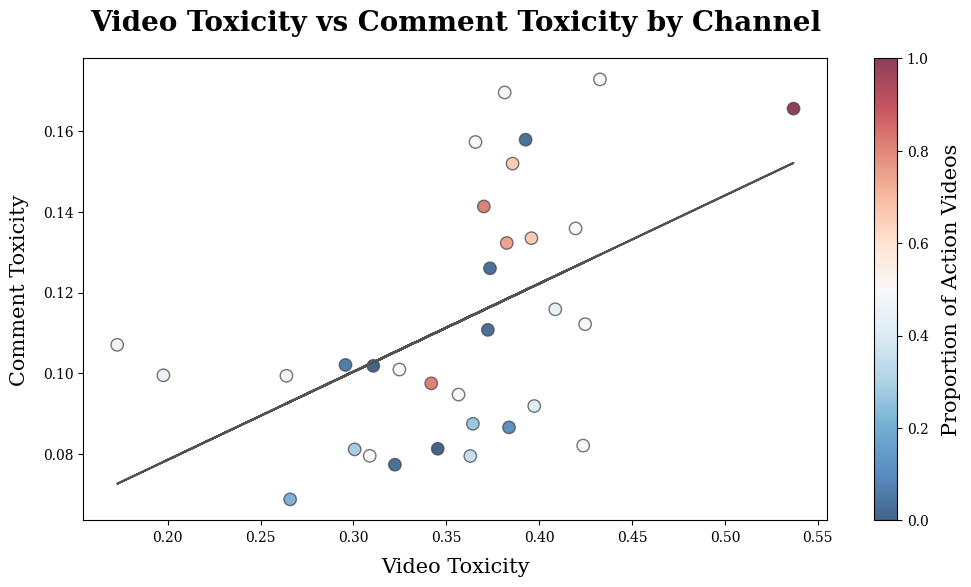

In [8]:
# Create the scatterplot
plt.rcParams.update({"font.family": "serif"})
fig, ax = plt.subplots(figsize=(12, 6))

scatter = ax.scatter(channel_toxicity["video_toxicity"], 
                     channel_toxicity["comment_toxicity"], 
                     c=channel_toxicity["action_proportion"], 
                     cmap='RdBu_r', alpha=0.75, s=80, edgecolor="#474747")

# Add the colorbar
cbar = plt.colorbar(scatter)
cbar.set_label("Proportion of Action Videos", size=15, labelpad=10)

# Add the trendline
z = np.polyfit(channel_toxicity["video_toxicity"], 
               channel_toxicity["comment_toxicity"], 1)
p = np.poly1d(z)
ax.plot(channel_toxicity["video_toxicity"], 
        p(channel_toxicity["video_toxicity"]), c="#525252")

# Set title and labels
ax.set_title("Video Toxicity vs Comment Toxicity by Channel", size=20, weight="bold", pad=20)
ax.set_xlabel("Video Toxicity", size=15, labelpad=10)
ax.set_ylabel("Comment Toxicity", size=15, labelpad=10)

# Display the plot
plt.savefig("../viz/05a-channel-video-vs-comment-toxicity-avg.png", dpi=300, transparent=True)
plt.show()

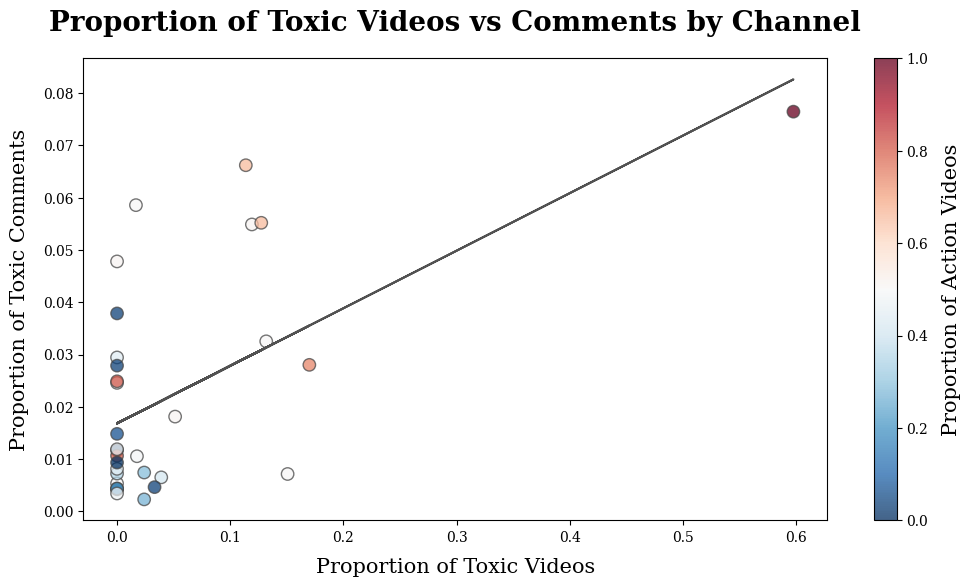

In [9]:
# Create the scatterplot
plt.rcParams.update({"font.family": "serif"})
fig, ax = plt.subplots(figsize=(12, 6))

scatter = ax.scatter(channel_toxicity["video_toxicity_proportion"], 
                     channel_toxicity["comment_toxicity_proportion"], 
                     c=channel_toxicity["action_proportion"], 
                     cmap='RdBu_r', alpha=0.75, s=80, edgecolor="#474747")

# Add the colorbar
cbar = plt.colorbar(scatter)
cbar.set_label("Proportion of Action Videos", size=15, labelpad=10)

# Add the trendline
z = np.polyfit(channel_toxicity["video_toxicity_proportion"], 
               channel_toxicity["comment_toxicity_proportion"], 1)
p = np.poly1d(z)
ax.plot(channel_toxicity["video_toxicity_proportion"], 
        p(channel_toxicity["video_toxicity_proportion"]), c="#525252")

# Set title and labels
ax.set_title("Proportion of Toxic Videos vs Comments by Channel", size=20, weight="bold", pad=20)
ax.set_xlabel("Proportion of Toxic Videos", size=15, labelpad=10)
ax.set_ylabel("Proportion of Toxic Comments", size=15, labelpad=10)

# Display the plot
plt.savefig("../viz/05a-channel-video-vs-comment-toxicity-pct.png", dpi=300, transparent=True)
plt.show()

### Game

#### Video Toxicity vs Comment Toxicity

In [10]:
# Game keywords
games = [
    "call of duty", "gta", "the last of us", "god of war", "cyberpunk", 
    "red dead redemption", "fallout", "elden ring", "assassin's creed", 
    "star wars jedi", "resident evil", "tomb raider", "minecraft", 
    "pokemon go", "just dance", "it takes two", "uncharted", "brawl stars"
]

# Extract the game from video titles
yt["video_game"] = yt["video_title"]\
    .apply(lambda title: ", ".join([g for g in games if g.lower() in title.lower()]))
yt["video_game"][:5]

0    elden ring
1    elden ring
2    elden ring
3    elden ring
4    elden ring
Name: video_game, dtype: object

In [11]:
# Inspect games in both categories
len(yt[yt["video_game"].str.contains(", ")]["video_title"].unique())

58

In [12]:
# Number of videos in each genre for each game
game_toxicity = yt[~yt["video_game"].str.contains(", ")]\
    .groupby("video_game").agg(
        num_videos=("video_id", pd.Series.nunique),
        video_toxicity=("video_toxicity", "mean"),
        video_toxicity_proportion=("video_toxicity_label", "mean"),
        comment_toxicity=("comment_toxicity", "mean"),
        comment_toxicity_proportion=("comment_toxicity_label", "mean"),
        genre=("video_genre", lambda x: x.value_counts().idxmax()) #lambda x: set(x))
    ).reset_index()

game_toxicity.sort_values(by="comment_toxicity", ascending=False).head()

,video_game,num_videos,video_toxicity,video_toxicity_proportion,comment_toxicity,comment_toxicity_proportion,genre
12,resident evil,72,0.409663,0.083519,0.161483,0.055633,action
3,cyberpunk,10,0.368979,0.000000,0.155304,0.058568,action
14,the last of us,18,0.340493,0.000000,0.151651,0.046162,action
6,god of war,47,0.347935,0.022065,0.148428,0.045234,action
4,elden ring,21,0.373076,0.050050,0.143955,0.040541,action


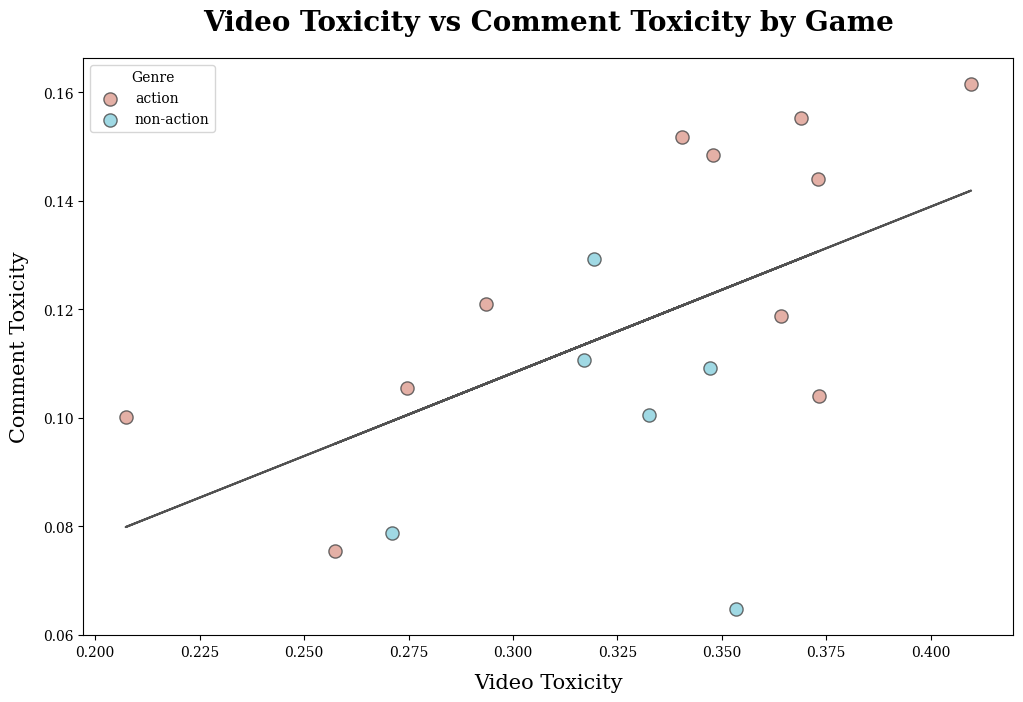

In [13]:
# Create the scatterplot
plt.rcParams.update({"font.family": "serif"})
fig, ax = plt.subplots(figsize=(12, 7.5))

# Set the color scheme
colors = {"action": "#DE9D90", "non-action": "#89D0DE"}

for genre, color in colors.items():
    i = game_toxicity["genre"] == genre
    ax.scatter(game_toxicity["video_toxicity"].loc[i], 
               game_toxicity["comment_toxicity"].loc[i], 
               c=color, label=genre,
               alpha=0.8, s=90, edgecolor="#474747")

# Add the trendline
z = np.polyfit(game_toxicity["video_toxicity"], game_toxicity["comment_toxicity"], 1)
p = np.poly1d(z)
ax.plot(game_toxicity["video_toxicity"], p(game_toxicity["video_toxicity"]), c="#525252")

# Set title and labels
ax.set_title("Video Toxicity vs Comment Toxicity by Game", size=20, weight="bold", pad=20)
ax.set_xlabel("Video Toxicity", size=15, labelpad=10)
ax.set_ylabel("Comment Toxicity", size=15, labelpad=10)
ax.legend(title="Genre", loc="best")

# Display the plot
plt.savefig("../viz/05b-game-video-vs-comment-toxicity-avg.png", dpi=300, transparent=True)
plt.show()

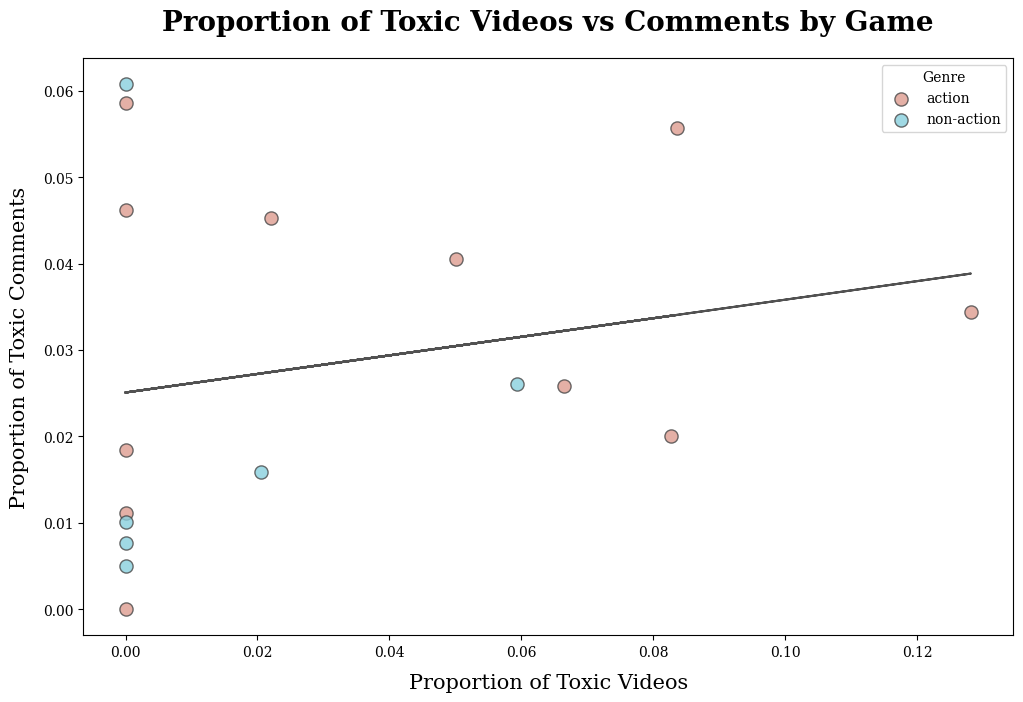

In [14]:
# Create the scatterplot
plt.rcParams.update({"font.family": "serif"})
fig, ax = plt.subplots(figsize=(12, 7.5))

# Set the color scheme
colors = {"action": "#DE9D90", "non-action": "#89D0DE"}

for genre, color in colors.items():
    i = game_toxicity["genre"] == genre
    ax.scatter(game_toxicity["video_toxicity_proportion"].loc[i], 
               game_toxicity["comment_toxicity_proportion"].loc[i], 
               c=color, label=genre,
               alpha=0.8, s=90, edgecolor="#474747")

# Add the trendline
z = np.polyfit(game_toxicity["video_toxicity_proportion"], game_toxicity["comment_toxicity_proportion"], 1)
p = np.poly1d(z)
ax.plot(game_toxicity["video_toxicity_proportion"], p(game_toxicity["video_toxicity_proportion"]), c="#525252")

# Set title and labels
ax.set_title("Proportion of Toxic Videos vs Comments by Game", size=20, weight="bold", pad=20)
ax.set_xlabel("Proportion of Toxic Videos", size=15, labelpad=10)
ax.set_ylabel("Proportion of Toxic Comments", size=15, labelpad=10)
ax.legend(title="Genre", loc="best")

# Display the plot
plt.savefig("../viz/05b-game-video-vs-comment-toxicity-pct.png", dpi=300, transparent=True)
plt.show()

### Video

In [15]:
# Extract video features
video_toxicity = yt.groupby("video_id").agg(
    video_title=("video_title", "first"),
    video_genre=("video_genre", "max"),
    video_toxicity=("video_toxicity", "mean"),
    comment_toxicity=("comment_toxicity", "mean"),
    comment_toxicity_proportion=("comment_toxicity_label", "mean"),
    comment_severe_toxicity=("comment_severe_toxicity", "mean"),
    comment_identity_attack=("comment_identity_attack", "mean"),
    comment_insult=("comment_insult", "mean"),
    comment_profanity=("comment_profanity", "mean"),
    comment_threat=("comment_threat", "mean"),
    video_speed=("video_speed", "mean"), 
    video_duration=("video_duration", "mean"),
    video_blocked_wordcount=("video_blocked_wordcount", "mean"),  
    video_blocked_proportion=("video_blocked_proportion", "mean")  
).reset_index()

video_toxicity.head(3)

,video_id,video_title,video_genre,video_toxicity,comment_toxicity,comment_toxicity_proportion,comment_severe_toxicity,comment_identity_attack,comment_insult,comment_profanity,comment_threat,video_speed,video_duration,video_blocked_wordcount,video_blocked_proportion
0,-0h5CX83r3s,Minecraft NOOB vs. PRO: Security Bunker BUILD ...,non-action,0.229591,0.062127,0.0,0.003999,0.006838,0.027790,0.035758,0.013447,3.329756,1025.0,0.0,0.0
1,-3zzJ9fxhhU,World’s *BEST* Minecraft Hamster MAZE! (Must See),non-action,0.271151,0.078417,0.0,0.004595,0.008842,0.025132,0.045378,0.015528,2.888218,662.0,0.0,0.0
2,-D3gRhe8AhY,playing GTA 5 with TWIN BROTHER!,action,0.246858,0.096161,0.0,0.006459,0.010867,0.040530,0.060806,0.018481,2.896825,252.0,0.0,0.0


#### Overall Comment Toxicity

In [16]:
# Toxicity columns
comment_toxicity_cols = [
    "comment_toxicity", "comment_severe_toxicity", 
    "comment_identity_attack", "comment_insult", 
    "comment_profanity", "comment_threat"
]

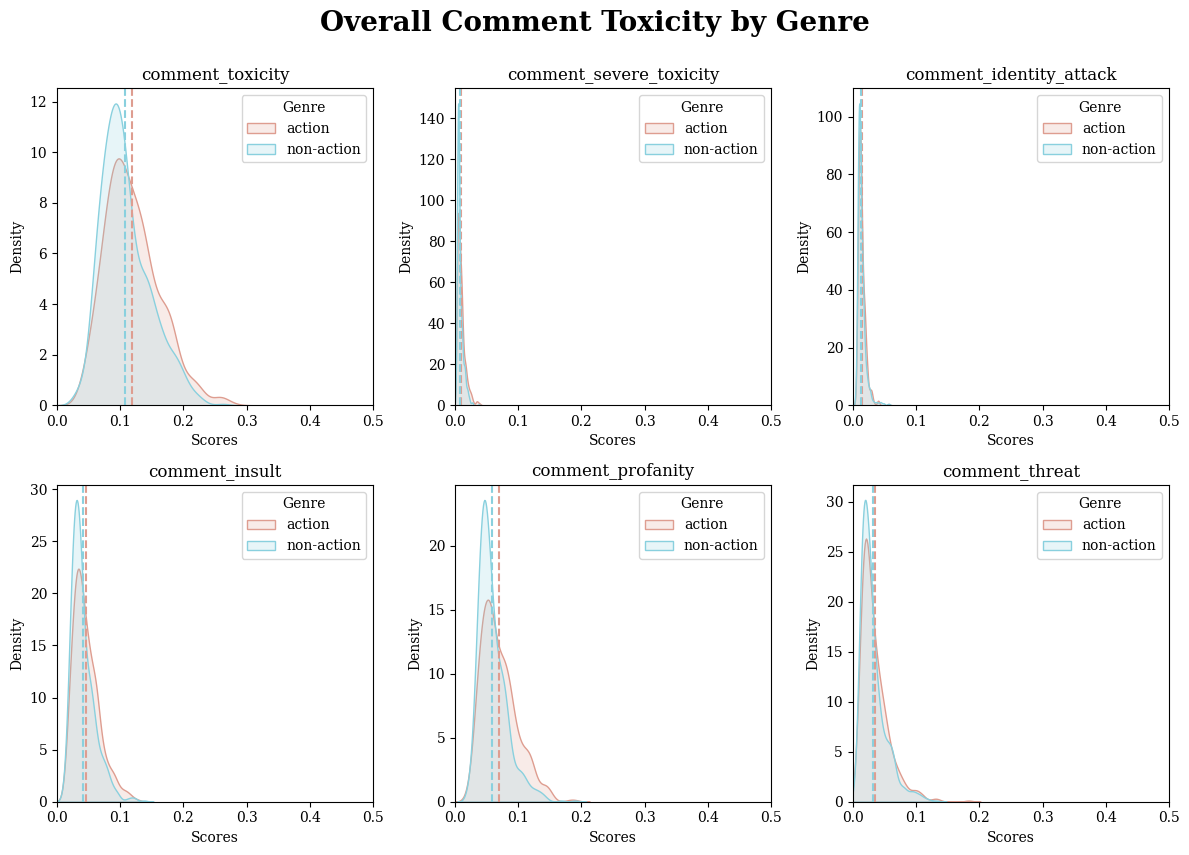

In [17]:
# Set up the figure with subplots
fig, axes = plt.subplots(nrows = 2, ncols = 3, figsize = (12, 8.5))

# Set the color scheme
colors = {"action": "#DE9D90", "non-action": "#89D0DE"}

# Visualize the distribution of data by channel
for i, col in enumerate(comment_toxicity_cols):
    for genre, group in video_toxicity.groupby("video_genre"):
        # Plot the density plot
        sns.kdeplot(group[col], ax = axes[i // 3, i % 3], 
                    fill = True, color = colors[genre], alpha = 0.2,
                    label = genre)
        # Plot the average line
        axes[i // 3, i % 3].axvline(group[col].mean(), 
                        linestyle = "--", 
                        color = colors[genre])
    axes[i // 3, i % 3].set_title(col)
    axes[i // 3, i % 3].set_xlabel("Scores")
    axes[i // 3, i % 3].set_ylabel("Density")
    axes[i // 3, i % 3].set_xlim(0, 0.5)
    axes[i // 3, i % 3].legend(title = "Genre")

# Display the plot
fig.suptitle("Overall Comment Toxicity by Genre", 
             size = 20, weight = "bold", y = 1)
fig.tight_layout()
plt.savefig("../viz/05c-video-overall-comment-toxicity-by-genre.png", dpi=300, transparent=True)
plt.show()

#### Hypothesis Testing

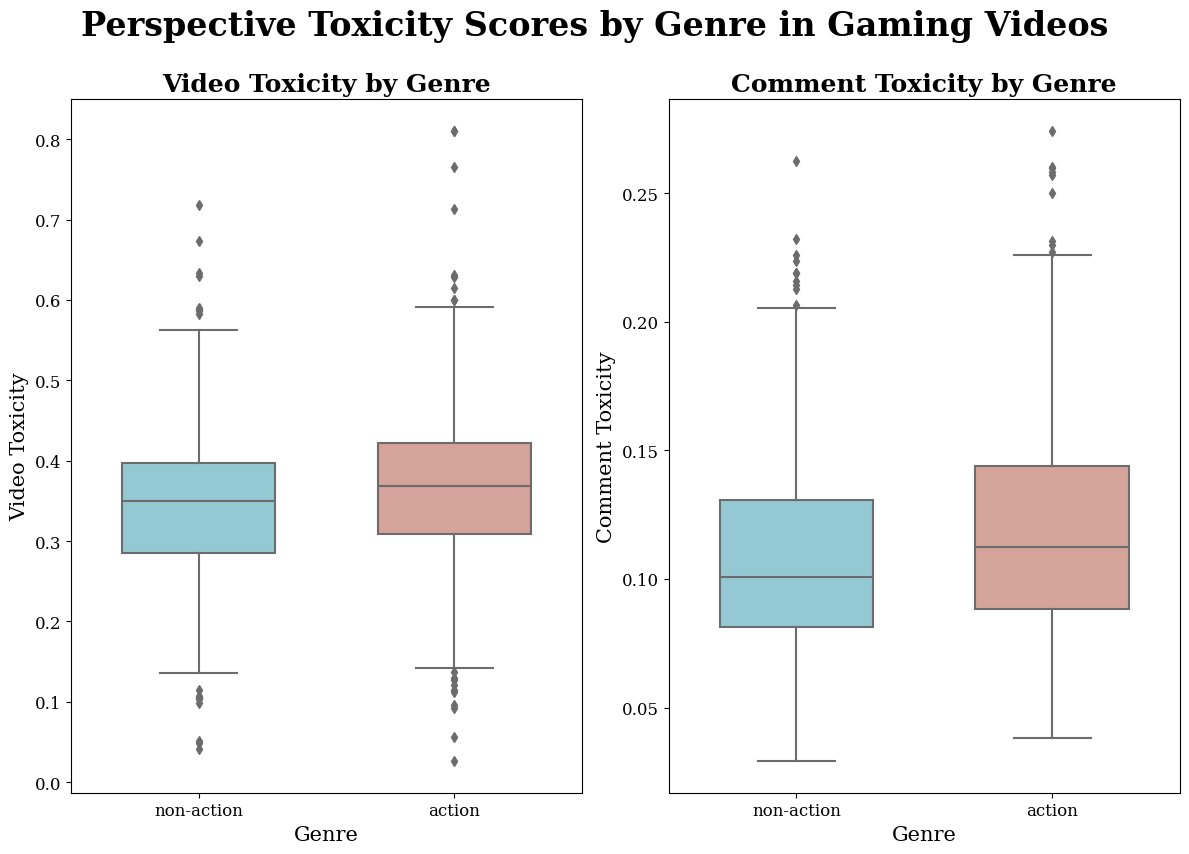

In [18]:
# Set up the figure with subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 8.5))

# Set the color scheme
colors = {"action": "#DE9D90", "non-action": "#89D0DE"}

# Visualize video toxicity
sns.boxplot(x="video_genre", y="video_toxicity", data=video_toxicity,
            ax=axes[0], palette=colors, width=0.6)
axes[0].set_title("Video Toxicity by Genre", size=18, weight="bold")
axes[0].set_xlabel("Genre", size=15)
axes[0].set_ylabel("Video Toxicity", size=15)
axes[0].tick_params(axis="x", labelsize=12)
axes[0].tick_params(axis="y", labelsize=12)

# Visualize comment toxicity
sns.boxplot(x="video_genre", y="comment_toxicity", data=video_toxicity,
            ax=axes[1], palette=colors, width=0.6)
axes[1].set_title("Comment Toxicity by Genre", size=18, weight="bold")
axes[1].set_xlabel("Genre", size=15)
axes[1].set_ylabel("Comment Toxicity", size=15)
axes[1].tick_params(axis="x", labelsize=12)
axes[1].tick_params(axis="y", labelsize=12)

# Display the plot
fig.suptitle("Perspective Toxicity Scores by Genre in Gaming Videos", 
             size = 24, weight = "bold", y = 1)
fig.tight_layout()
plt.savefig("../viz/05c-video-toxicity-by-genre-distribution.png", dpi=300, transparent=True)
plt.show()

In [19]:
# Perform Mann-Whitney U test
alpha = 0.05
results = []
for col in comment_toxicity_cols:
    # Define the sampels
    s1 = video_toxicity[video_toxicity["video_genre"] == "non-action"][col]
    s2 = video_toxicity[video_toxicity["video_genre"] == "action"][col]
    
    # Perform Mann-Whiteney U test
    u, p = stats.mannwhitneyu(s1, s2, alternative="less")
    median1 = np.median(s1)
    median2 = np.median(s2)
    n1 = len(s1)
    n2 = len(s2)
    
    # Append results to the list
    results.append({
        "Toxicity Type": col,
        "MWU Test Statistic": u,
        "p-value": p,
        "Non-Action Sample Size": n1,
        "Action Sample Size": n2,
        "Non-Action median": median1,
        "Action Median": median2
    })
    
# Convert to DataFrame
mwu = pd.DataFrame(results)
mwu.style.hide(axis = "index")\
             .apply(lambda x: np.where(x < 0.05, "background: #C5E1E7", ""), 
                    subset = ["p-value"], axis = 0)

Toxicity Type,MWU Test Statistic,p-value,Non-Action Sample Size,Action Sample Size,Non-Action median,Action Median
comment_toxicity,175475.000000,0.000002,750,551,0.100874,0.112624
comment_severe_toxicity,168427.000000,0.000000,750,551,0.006249,0.008053
comment_identity_attack,182850.000000,0.000192,750,551,0.011633,0.012405
comment_insult,172045.000000,0.000000,750,551,0.035757,0.041462
comment_profanity,158792.000000,0.000000,750,551,0.053160,0.062773
comment_threat,187804.000000,0.002472,750,551,0.025645,0.027943


#### Video Toxicity vs Comment Toxicity

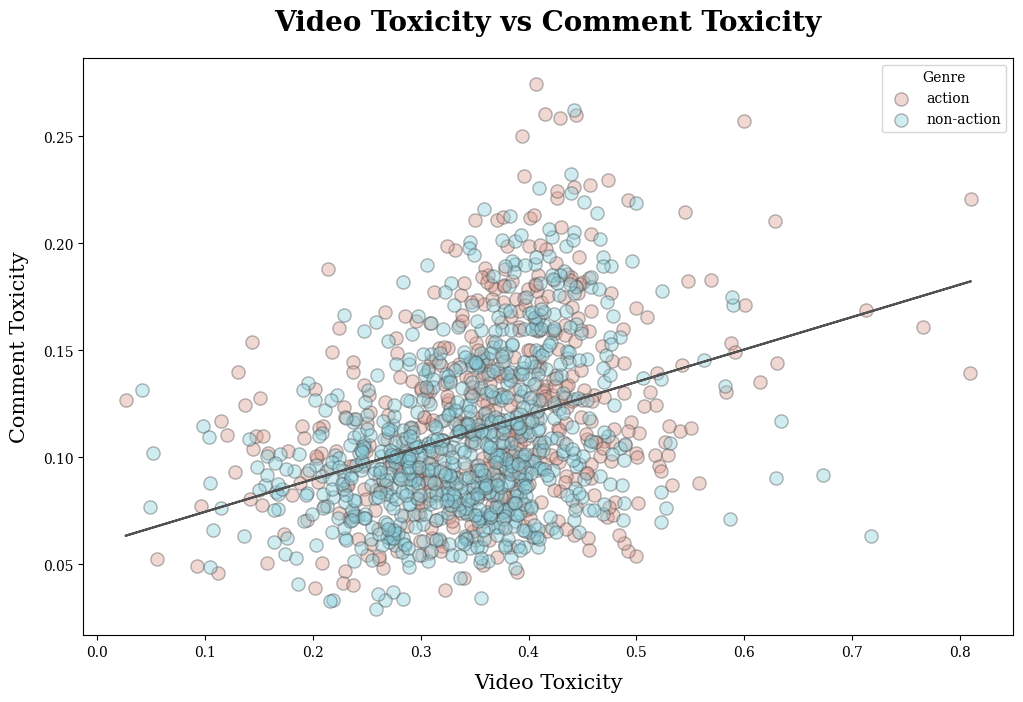

In [20]:
# Create the scatterplot
plt.rcParams.update({"font.family": "serif"})
fig, ax = plt.subplots(figsize=(12, 7.5))

# Set the color scheme
colors = {"action": "#DE9D90", "non-action": "#89D0DE"}

for genre, color in colors.items():
    i = video_toxicity["video_genre"] == genre
    ax.scatter(video_toxicity["video_toxicity"].loc[i], 
               video_toxicity["comment_toxicity"].loc[i], 
               c=color, label=genre,
               alpha=0.4, s=90, edgecolor="#474747")

# Add the trendline
z = np.polyfit(video_toxicity["video_toxicity"], video_toxicity["comment_toxicity"], 1)
p = np.poly1d(z)
ax.plot(video_toxicity["video_toxicity"], p(video_toxicity["video_toxicity"]), c="#525252")

# Set title and labels
ax.set_title("Video Toxicity vs Comment Toxicity", size=20, weight="bold", pad=20)
ax.set_xlabel("Video Toxicity", size=15, labelpad=10)
ax.set_ylabel("Comment Toxicity", size=15, labelpad=10)
ax.legend(title="Genre", loc="best")

# Display the plot
plt.savefig("../viz/05c-video-video-vs-comment-toxicity-avg.png", dpi=300, transparent=True)
plt.show()

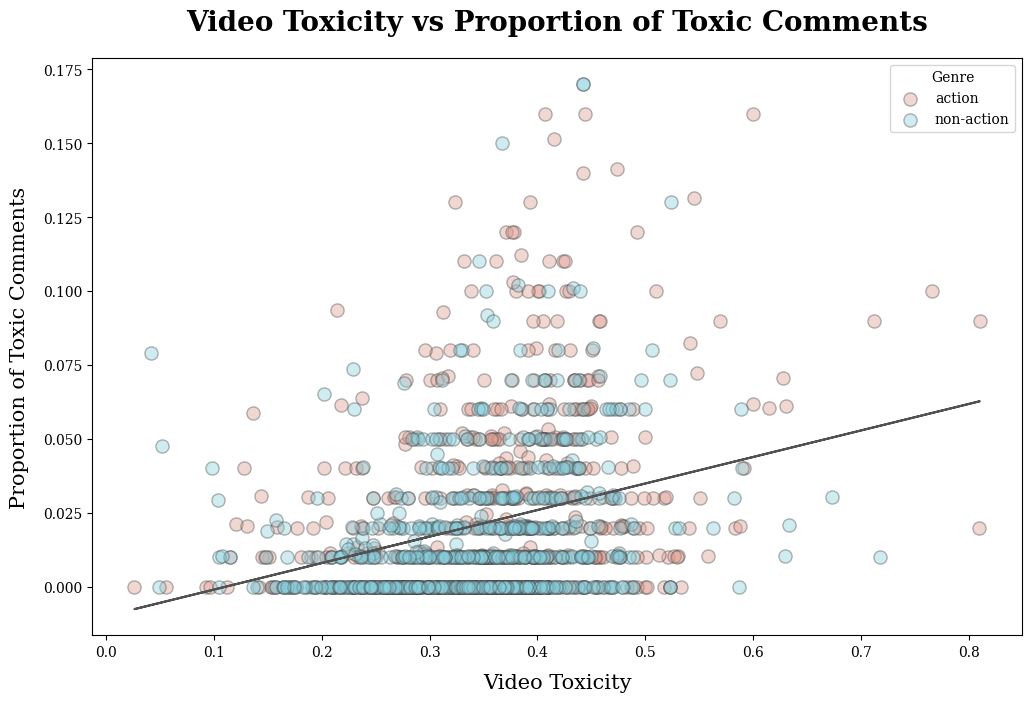

In [21]:
# Create the scatterplot
plt.rcParams.update({"font.family": "serif"})
fig, ax = plt.subplots(figsize=(12, 7.5))

# Set the color scheme
colors = {"action": "#DE9D90", "non-action": "#89D0DE"}

for genre, color in colors.items():
    i = video_toxicity["video_genre"] == genre
    ax.scatter(video_toxicity["video_toxicity"].loc[i], 
               video_toxicity["comment_toxicity_proportion"].loc[i], 
               c=color, label=genre,
               alpha=0.4, s=90, edgecolor="#474747")

# Add the trendline
z = np.polyfit(video_toxicity["video_toxicity"], video_toxicity["comment_toxicity_proportion"], 1)
p = np.poly1d(z)
ax.plot(video_toxicity["video_toxicity"], p(video_toxicity["video_toxicity"]), c="#525252")

# Set title and labels
ax.set_title("Video Toxicity vs Proportion of Toxic Comments", size=20, weight="bold", pad=20)
ax.set_xlabel("Video Toxicity", size=15, labelpad=10)
ax.set_ylabel("Proportion of Toxic Comments", size=15, labelpad=10)
ax.legend(title="Genre", loc="best")

# Display the plot
plt.savefig("../viz/05c-video-video-vs-comment-toxicity-pct.png", dpi=300, transparent=True)
plt.show()

#### Video Blocked Words vs Comment Toxicity

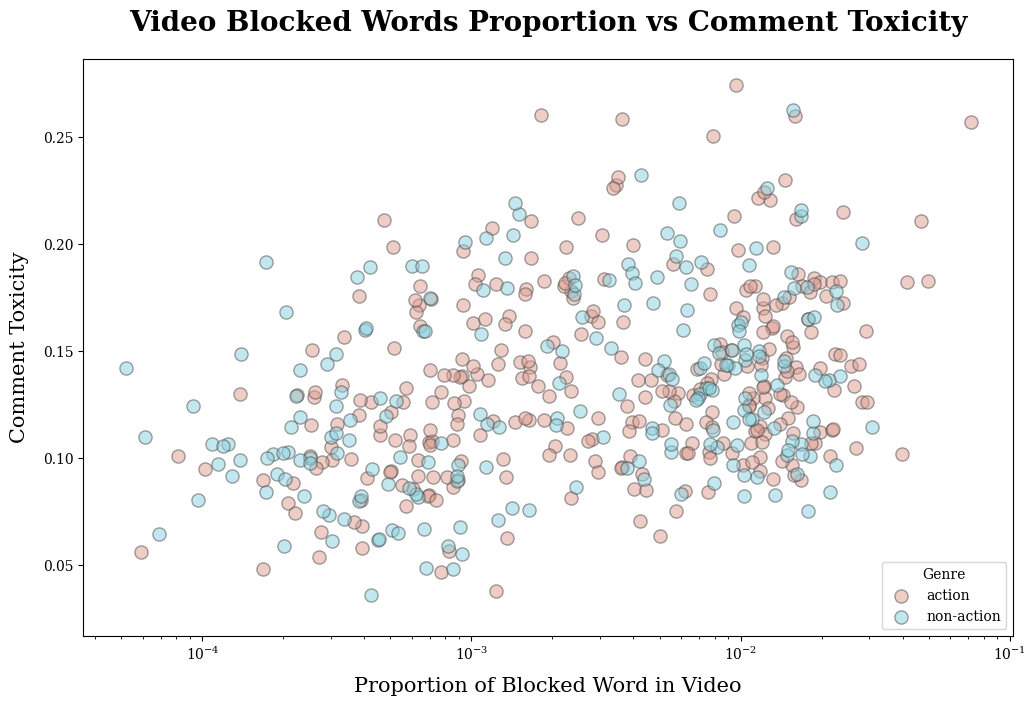

In [22]:
# Create the scatterplot
plt.rcParams.update({"font.family": "serif"})
fig, ax = plt.subplots(figsize=(12, 7.5))

# Set the color scheme
colors = {"action": "#DE9D90", "non-action": "#89D0DE"}

for genre, color in colors.items():
    i = video_toxicity["video_genre"] == genre
    ax.scatter(video_toxicity["video_blocked_proportion"].loc[i], 
               video_toxicity["comment_toxicity"].loc[i], 
               c=color, label=genre,
               alpha=0.5, s=90, edgecolor="#474747")

# # Add the trendline
# z = np.polyfit(video_toxicity["video_blocked_proportion"], video_toxicity["comment_toxicity"], 1)
# p = np.poly1d(z)
# ax.plot(video_toxicity["video_blocked_proportion"], p(video_toxicity["video_blocked_proportion"]), c="#525252")

# Set title and labels
ax.set_title("Video Blocked Words Proportion vs Comment Toxicity", size=20, weight="bold", pad=20)
ax.set_xlabel("Proportion of Blocked Word in Video", size=15, labelpad=10)
ax.set_ylabel("Comment Toxicity", size=15, labelpad=10)
ax.legend(title="Genre", loc="lower right")
ax.set_xscale("log")

# Display the plot
plt.savefig("../viz/05c-video-blocked-vs-comment-toxicity-avg.png", dpi=300, transparent=True)
plt.show()

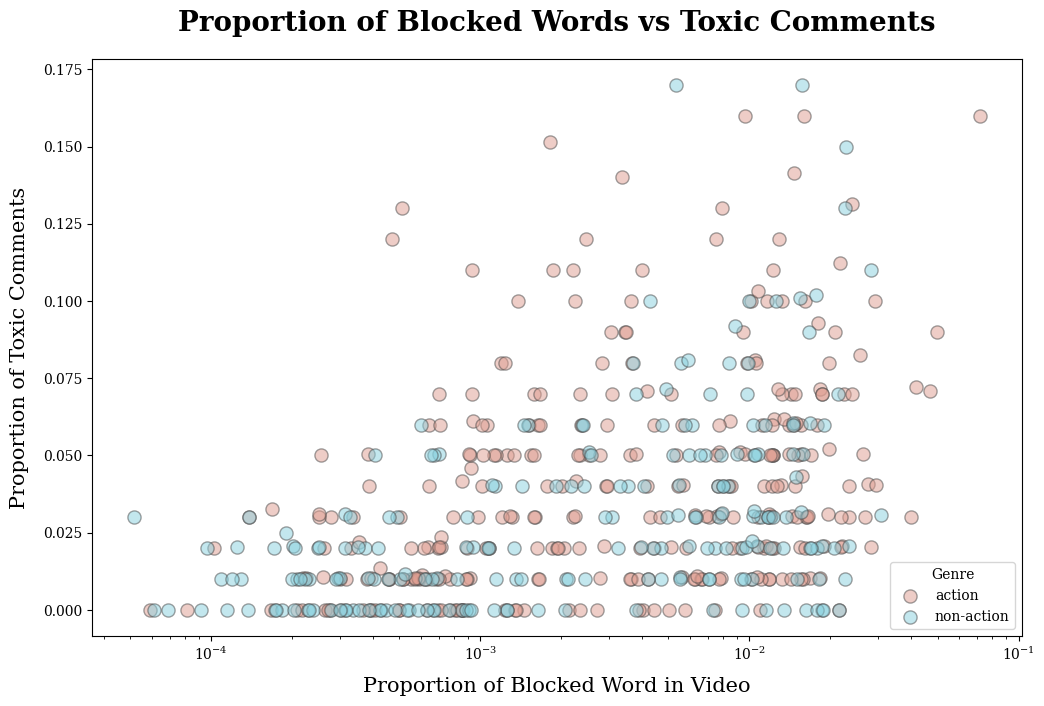

In [23]:
# Create the scatterplot
plt.rcParams.update({"font.family": "serif"})
fig, ax = plt.subplots(figsize=(12, 7.5))

# Set the color scheme
colors = {"action": "#DE9D90", "non-action": "#89D0DE"}

for genre, color in colors.items():
    i = video_toxicity["video_genre"] == genre
    ax.scatter(video_toxicity["video_blocked_proportion"].loc[i], 
               video_toxicity["comment_toxicity_proportion"].loc[i], 
               c=color, label=genre,
               alpha=0.5, s=90, edgecolor="#474747")

# # Add the trendline
# z = np.polyfit(video_toxicity["video_blocked_proportion"], video_toxicity["comment_toxicity"], 1)
# p = np.poly1d(z)
# ax.plot(video_toxicity["video_blocked_proportion"], p(video_toxicity["video_blocked_proportion"]), c="#525252")

# Set title and labels
ax.set_title("Proportion of Blocked Words vs Toxic Comments", size=20, weight="bold", pad=20)
ax.set_xlabel("Proportion of Blocked Word in Video", size=15, labelpad=10)
ax.set_ylabel("Proportion of Toxic Comments", size=15, labelpad=10)
ax.legend(title="Genre", loc="lower right")
ax.set_xscale("log")

# Display the plot
plt.savefig("../viz/05c-video-blocked-vs-comment-toxicity-pct.png", dpi=300, transparent=True)
plt.show()

#### Linear Regression

In [24]:
# Log transformation
video_toxicity["video_blocked_proportion_log"] = \
    np.log(video_toxicity["video_blocked_proportion"] + 1e-9)

# Create dummy variable
video_toxicity["genre_action"] = (video_toxicity["video_genre"] == "action").astype(int)
video_toxicity["video_toxic"] = (video_toxicity["video_toxicity"] > 0.5).astype(int)

# Fit the model
m = ols("comment_toxicity ~ genre_action + video_toxicity + video_blocked_proportion_log", 
        data=video_toxicity).fit()

# Print the summary
m.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       comment_toxicity   R-squared:                       0.249
Model:                            OLS   Adj. R-squared:                  0.247
Method:                 Least Squares   F-statistic:                     143.5
Date:                Fri, 08 Mar 2024   Prob (F-statistic):           2.73e-80
Time:                        23:31:47   Log-Likelihood:                 2508.6
No. Observations:                1301   AIC:                            -5009.
Df Residuals:                    1297   BIC:                            -4989.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept                        0.1108      0.005     20.856      0.000       0.100       0.121
genre_action                    -0.0003      0.002     -0.143      0.887      -0.004       0.004
video_toxicity                   0.0947      0.011      8.457      0.000       0.073       0.117
video_blocked_proportion_log     0.0021      0.000     14.459      0.000       0.002       0.002
==============================================================================
Omnibus:                       57.129   Durbin-Watson:                   1.939
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               63.601
Skew:                           0.529   Prob(JB):                     1.55e-14
Kurtosis:                       3.228   Cond. No.                         205.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [25]:
# Fit the model
m = ols("comment_toxicity_proportion ~ genre_action + video_toxic + video_blocked_proportion_log", 
        data=video_toxicity).fit()

# Print the summary
m.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:     comment_toxicity_proportion   R-squared:                       0.227
Model:                                     OLS   Adj. R-squared:                  0.226
Method:                          Least Squares   F-statistic:                     127.2
Date:                         Fri, 08 Mar 2024   Prob (F-statistic):           3.25e-72
Time:                                 23:31:47   Log-Likelihood:                 2979.0
No. Observations:                         1301   AIC:                            -5950.
Df Residuals:                             1297   BIC:                            -5929.
Df Model:                                    3                                         
Covariance Type:                     nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept                        0.0427      0.002     23.211      0.000       0.039       0.046
genre_action                     0.0050      0.001      3.475      0.001       0.002       0.008
video_toxic                      0.0140      0.003      3.999      0.000       0.007       0.021
video_blocked_proportion_log     0.0016   9.69e-05     16.663      0.000       0.001       0.002
==============================================================================
Omnibus:                      416.819   Durbin-Watson:                   2.063
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1390.319
Skew:                           1.571   Prob(JB):                    1.25e-302
Kurtosis:                       6.973   Cond. No.                         84.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### Logistic Regression

In [26]:
# Extract video features
# video_features = pd.get_dummies(
#     data=yt[["video_genre", "video_live", "video_game"]],
#     drop_first=True).columns.tolist() + ["video_blocked_proportion"]
yt["video_action"] = (yt["video_genre"] == "action").astype(int)
video_features = pd.get_dummies(
    data=yt[["video_live"]],drop_first=True)\
.columns.tolist() + ["video_blocked_proportion"] + ["video_action"]

# Extract toxicity features
toxicity_features = yt.iloc[:,25:31].columns.tolist()

# Mask for sparse columns
mask = yt.iloc[:, 32:232].apply(lambda x: (x == 0).mean()) < 0.5
# Extract sentiment features
sentiment_features = yt.iloc[:,32:232].columns[mask].tolist()

# Create the formula
features = video_features + toxicity_features + sentiment_features
formula = "comment_toxicity_label ~ " + " + ".join(features)

In [27]:
# Fit the model
m = logit(formula, data=yt).fit()
summary = m.summary2().tables[1]
summary[summary["P>|z|"] < 0.05].sort_values(by="P>|z|")

Optimization terminated successfully.
         Current function value: 0.097551
         Iterations 12


,Coef.,Std.Err.,z,P>|z|,[0.025,0.975]
video_blocked_proportion,42.581844,3.603548,11.816645,3.202184e-32,35.519020,49.644667
video_journalism,98.371136,15.583327,6.312589,2.744055e-10,67.828377,128.913895
video_action,0.403760,0.069241,5.831191,5.503325e-09,0.268049,0.539471
video_wealthy,71.700837,14.676709,4.885348,1.032462e-06,42.935016,100.466659
video_sexual,48.128896,10.688444,4.502891,6.703538e-06,27.179930,69.077861
video_wedding,40.687108,9.823635,4.141757,3.446556e-05,21.433137,59.941079
video_shopping,35.003645,8.550354,4.093824,4.243166e-05,18.245259,51.762031
video_sadness,69.209889,17.542558,3.945256,7.971466e-05,34.827106,103.592671
video_affection,-69.757144,17.716046,-3.937512,8.233084e-05,-104.479957,-35.034331
video_feminine,-46.216659,11.780233,-3.923238,8.736679e-05,-69.305492,-23.127825
